## Notebook to implement AB testing after Model Evaluation

In [14]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 118 (delta 68), reused 74 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (118/118), 629.58 KiB | 1.33 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/InkubaLM-Challenge/InkubaLM-Challenge


In [15]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge/InkubaLM-Challenge
Already up to date.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -U trl bitsandbytes
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import sys
sys.path.append("..")  # Add parent directory to the path

import os
from typing import List
from pathlib import Path
import numpy as np

# DO NOT EDIT
# create submission file
import pandas as pd
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
)
from utils import (
    eval,
    model_function,
    multitask,
    experiment_logger
    )

import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, concatenate_datasets, Dataset, Value
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import PeftModel

In [6]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [7]:
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

from huggingface_hub import login

try:
    from google.colab import userdata

    # Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
    # vars as appropriate for your system.
    # userdata.get("HF_TOKEN") indicates that the name of the token in the Colab env is HF_TOKEN
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
except:
    os.environ["HF_TOKEN"] = "----"

login(token=os.environ["HF_TOKEN"])

token = os.environ["HF_TOKEN"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:

print("# Loading datasets")
train_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")

print("\n# Example from training dataset:")
print(train_dataset[0])

print("\n# Example from test dataset:")
print(test_dataset[0])

print("# Converting to DataFrame and extracting task types")
train_df = train_dataset.to_pandas()
train_df['task'] = train_df.ID.apply(multitask.extract_task_from_id)

print("\n# Dataset distribution by task:")
print(train_df.task.value_counts())



# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Common Columns: ['targets', 'langs', 'instruction', 'inputs', 'ID']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

Common Columns: ['targets', 'langs', 'instruction', 'inputs', 'ID']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]


# Example from training dataset:
{'ID': 'ID_6aba33a1_sentiment_ dev_hausa', 'langs': 'hausa', 'instruction': 'Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.', 'inputs': '@user @user allah ya tsayyaba yar uwa 🎂 😍', 'targets': 'Kyakkyawa'}

# Example from test dataset:
{'ID': 'ID_f3c74c7b_sentiment_test__hausa', 'langs': 'hausa', 'instruction': "Gano ra'ayin da aka bayyana a cikin wannan rubutu. Bin waɗannan jagororin, kyakkyawa yana na rubutu na nufin kyakkyawan tunani, ɗabi'a, da motsin rai. Korau na nuna rubutu na nufin mummunan tunani ko motsin rai. Tsaka-tsaki na nuna rubutu baya nufin magana mai kyau ko mara kyau kai tsaye ko a kaikaice.", 'inputs': '@user ynxu fha da kanada kudi shikenan duk kayan nan zasu iya zama naka no🧢', 'targets': None}
# Conv

## Still balancing dataset

## Load the original base model

In [30]:

from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # or load_in_8bit=True for 8-bit quantization
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # or "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16  # or torch.float16, depending on your hardware
)

model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name)

model = multitask.apply_lora_adapters(model)

trainable params: 524,288 || all params: 422,463,488 || trainable%: 0.1241


In [31]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(model_name)
balanced_df = multitask.balance_target_lengths(train_df, tokenizer=lambda x: tok.tokenize(x))

print("\n# Analyzing target sequence lengths after balancing")
task_stats_after = multitask.analyze_task_lengths(balanced_df)

balanced_dataset = Dataset.from_pandas(balanced_df.reset_index(drop=True))


# Analyzing target sequence lengths after balancing
Target sequence length analysis by task:
Task: sentiment
count    400.0000
mean       7.0125
std        2.0756
min        4.0000
25%        5.0000
50%        7.5000
75%        9.0000
max        9.0000
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------
Task: afrixnli
count    400.0
mean      18.0
std        0.0
min       18.0
25%       18.0
50%       18.0
75%       18.0
max       18.0
Name: targets, dtype: float64
--------------------------------------------------


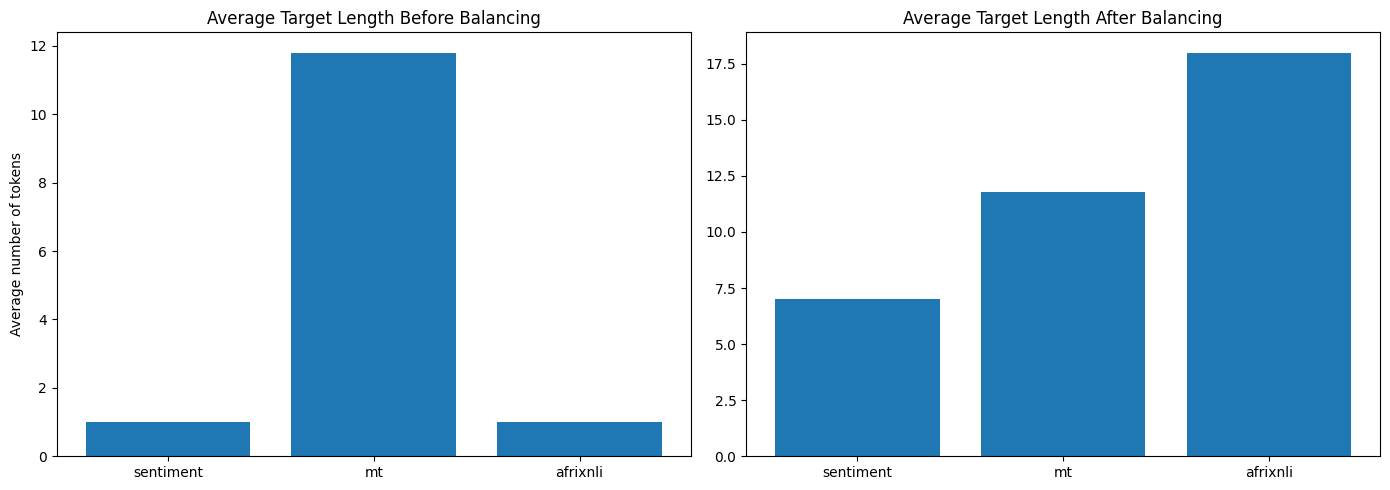

In [32]:
#testing balancing dataset more dynamically
multitask.plot_target_lengths(train_df, balanced_df)

## Splitting dataset into training and validation

In [28]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Stratified split (optional): to preserve task distribution
train_df_split, val_df_split = train_test_split(
    balanced_df,
    test_size=0.1,
    stratify=balanced_df["task"],
    random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_split.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df_split.reset_index(drop=True))


### Apply LoRA adapters

In [35]:
tok.pad_token = tok.eos_token


In [36]:

output_dir = "/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_balanced"
os.makedirs(output_dir, exist_ok=True)
# Train
balanced_val_trainer = multitask.setup_trainer_ab_testing(model, train_dataset, tokenizer=tok, output_dir=output_dir, val_dataset=val_dataset)
balanced_val_trainer.train()

Applying formatting function to train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1260 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/140 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
10,3.857600,3.423828
20,3.237300,3.316406
30,3.695500,3.240234
40,3.231500,3.189453
50,3.028400,3.138672
60,2.895400,3.087891
70,3.026300,3.046875
80,3.002100,3.003906
90,3.237700,2.962891
100,2.885500,2.921875


TrainOutput(global_step=945, training_loss=2.5330833798363095, metrics={'train_runtime': 665.7254, 'train_samples_per_second': 5.678, 'train_steps_per_second': 1.42, 'total_flos': 910953413591040.0, 'train_loss': 2.5330833798363095})

In [37]:
balanced_val_trainer.save_model("outputs/best_model_dynamic_balanced")
tok.save_pretrained("outputs/best_model_dynamic_balanced")


('outputs/best_model_dynamic_balanced/tokenizer_config.json',
 'outputs/best_model_dynamic_balanced/special_tokens_map.json',
 'outputs/best_model_dynamic_balanced/tokenizer.model',
 'outputs/best_model_dynamic_balanced/added_tokens.json',
 'outputs/best_model_dynamic_balanced/tokenizer.json')

In [42]:
balanced_val_trainer.model.save_pretrained("/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_balanced")


## Load balanced model with dynamic tokens

In [43]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig

# Load base model
base_model = AutoModelForCausalLM.from_pretrained("lelapa/InkubaLM-0.4B", device_map="auto")

# Load LoRA adapter
lora_model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_balanced"
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("lelapa/InkubaLM-0.4B")


In [54]:

zindi_score, dict_scores = eval.evaluate_zindi(os.path.join(
    output_path,
    "submission_test.csv")
)

In [57]:
balanced_val_trainer.evaluate()

{'eval_loss': 1.9685437679290771,
 'eval_runtime': 8.3866,
 'eval_samples_per_second': 16.693,
 'eval_steps_per_second': 4.173}

In [61]:

experiment_logger.log_experiment_auto(
    trainer=balanced_val_trainer,
    train_output=train_output,
    prompt_variant="balanced validation dataset",
    task_metrics=dict_scores,
    lb_score=dict_scores["zindi_score"],
    notes="validation dataset"
)

In [63]:
dict_scores

{'sentiment_f1': np.float64(0.303),
 'nli_f1': np.float64(0.2222),
 'mt_chrf': np.float64(0.0887),
 'zindi_score': np.float64(0.2046)}

In [62]:
zindi_score

np.float64(0.2046353846878363)

In [64]:

log_path = "/content/drive/MyDrive/InkubaLM/outputs/experiment_log.csv"
df = pd.read_csv(log_path)
df.head()  # Show first 5 rows



,run_id,date,model_name,prompt_variant,balanced,repetition_factor,epochs,train_loss,sentiment_f1,nli_f1,mt_chrf,zindi_score,notes
0,run_001,2025-03-25,InkubaLM + LoRA (rank=8),Instruction v3 + few-shot,True,11,3,1.888,0.303,0.2222,0.0887,0.2046,Overwritten for new metric format
1,run_2,2025-03-26,lelapa/InkubaLM-0.4B,balanced validation dataset,True,11,3,2.553,0.303,0.2222,0.0887,0.2046,"Added larger rank, new Swahili MT prompt"
2,run_3,2025-03-26,lelapa/InkubaLM-0.4B,balanced validation dataset,True,11,3,2.553,0.303,0.2222,0.0887,0.2046,validation dataset
